In [53]:
import pandas as pd
mappeddataset = "data/image_mapping.csv";

maped = pd.read_csv(mappeddataset, low_memory=False)

print("\n--- Columns ---")
print(maped.columns[:20])  # first 20 col names




--- Columns ---
Index(['idx', 'image_filename', 'ra', 'dec',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_weight',
       't01_smooth_or_features_a02_features_or_disk_fraction',
       't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
       't01_smooth_or_features_a02_features_or_disk_debiased',
       't01_smooth_or_features_a02_features_or_disk_flag',
       't01_smooth_or_features_a03_star_or_artifact_count',
       't01_smooth_or_features_a03_star_or_artifact_weight',
       't01_smooth_or_features_a03_star_or_artifact_fraction',
       't01_smooth_or_features_a03_star_or_artifact_weight

In [86]:
# -----------------------------
# 1️⃣ Imports
# -----------------------------
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [87]:
# -----------------------------
# 2️⃣ Load dataset
# -----------------------------
mapping_df = pd.read_csv("data/image_mapping.csv")
print("Dataset loaded:", mapping_df.shape)
print(mapping_df.columns)


Dataset loaded: (999, 172)
Index(['idx', 'image_filename', 'ra', 'dec',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       ...
       't09_bulge_shape_a26_boxy_fraction',
       't09_bulge_shape_a26_boxy_weighted_fraction',
       't09_bulge_shape_a26_boxy_debiased', 't09_bulge_shape_a26_boxy_flag',
       't09_bulge_shape_a27_no_bulge_count',
       't09_bulge_shape_a27_no_bulge_weight',
       't09_bulge_shape_a27_no_bulge_fraction',
       't09_bulge_shape_a27_no_bulge_weighted_fraction',
       't09_bulge_shape_a27_no_bulge_debiased',
       't09_bulge_shape_a27_no_bulge_flag'],
      dtype='object', length=172)


In [88]:
# Extended Multi-class labels
# 0 = Smooth, 1 = Edge-on, 2 = Spiral, 3 = Barred Spiral, 4 = Merger/Odd, 5 = Star/Artifact

def assign_extended_label(row):
    fractions = {
        0: row['t01_smooth_or_features_a01_smooth_fraction'],   # Smooth
        1: row['t02_edgeon_a04_yes_fraction'] if 't02_edgeon_a04_yes_fraction' in row else 0,  # Edge-on
        2: row['t04_spiral_a08_spiral_fraction'] if 't04_spiral_a08_spiral_fraction' in row else 0,  # Spiral
        3: row['t03_bar_a06_bar_fraction'] if 't03_bar_a06_bar_fraction' in row else 0,  # Barred Spiral
        4: row['t07_odd_a16_merger_fraction'] if 't07_odd_a16_merger_fraction' in row else 0,  # Merger/Odd
        5: row['t01_smooth_or_features_a03_star_or_artifact_fraction']  # Star/Artifact
    }
    # Return the class with the highest vote fraction
    return max(fractions, key=fractions.get)

mapping_df['extended-label'] = mapping_df.apply(assign_extended_label, axis=1)


In [89]:
print("\n-class label distribution:")
print(mapping_df['extended-label'].value_counts())


-class label distribution:
extended-label
0    501
2    383
3     64
1     49
5      2
Name: count, dtype: int64


In [90]:
# -----------------------------
# 4️⃣ PyTorch Dataset
# -----------------------------
class GalaxyDataset(Dataset):
    def __init__(self, df, label_type='binary', transform=None):
        self.df = df
        self.label_type = label_type
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_filename']
        label = self.df.iloc[idx][f'{self.label_type}_label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [91]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [92]:
multiclass_dataset = GalaxyDataset(mapping_df, label_type='extended', transform=transform)

In [93]:
# -----------------------------
# 5️⃣ Train/Test split
# -----------------------------
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

# binary_train, binary_test = split_dataset(binary_dataset)
multi_train, multi_test = split_dataset(multiclass_dataset)

# binary_train_loader = DataLoader(binary_train, batch_size=32, shuffle=True)
# binary_test_loader = DataLoader(binary_test, batch_size=32, shuffle=False)

multi_train_loader = DataLoader(multi_train, batch_size=32, shuffle=True)
multi_test_loader = DataLoader(multi_test, batch_size=32, shuffle=False)

In [94]:
# # -----------------------------
# # 6️⃣ CNN Model
# # -----------------------------

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)

        # Dummy input to compute flattened size
        self._to_linear = None
        self.convs(torch.zeros(1, 3, 128, 128))  # pass dummy input
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        if self._to_linear is None:
            self._to_linear = x.view(1, -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [95]:
# -----------------------------
# 7️⃣ Training Function
# -----------------------------
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

In [96]:
# -----------------------------
# 8️⃣ Evaluation Function
# -----------------------------
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

In [101]:
# # -----------------------------
# # 🔟 Train & Evaluate Multi-Class Classification (6 classes)
# # -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_model = SimpleCNN(num_classes=6)   # Changed from 3 → 6
criterion_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.Adam(multi_model.parameters(), lr=0.001)

train_model(multi_model, multi_train_loader, criterion_multi, optimizer_multi, device, epochs=10)
multi_acc = evaluate_model(multi_model, multi_test_loader, device)
print(f"Extended Multi-Class Classification Test Accuracy: {multi_acc:.2f}%")

# print(mapping_df.columns)  # should include 'extended_label'
# Rename the column to use underscore
# mapping_df.rename(columns={'extended-label': 'extended_label'}, inplace=True)

# Check it
# print(mapping_df.columns)
# y = mapping_df['extended_label'].values


Epoch 1/10: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch [1/10] Loss: 3.0275


Epoch 2/10: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch [2/10] Loss: 0.7743


Epoch 3/10: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch [3/10] Loss: 0.6914


Epoch 4/10: 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Epoch [4/10] Loss: 0.5876


Epoch 5/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch [5/10] Loss: 0.5380


Epoch 6/10: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch [6/10] Loss: 0.5128


Epoch 7/10: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Epoch [7/10] Loss: 0.4968


Epoch 8/10: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Epoch [8/10] Loss: 0.4166


Epoch 9/10: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Epoch [9/10] Loss: 0.4363


Epoch 10/10: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


Epoch [10/10] Loss: 0.3565
Extended Multi-Class Classification Test Accuracy: 81.50%


In [102]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader, device, class_names=None, num_images_to_show=5):
    model.eval()
    y_true = []
    y_pred = []
    images_list = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            images_list.extend(images.cpu())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Automatically handle class names
    if class_names is None:
        unique_classes = np.unique(np.concatenate([y_true, y_pred]))
        class_names = [str(c) for c in unique_classes]
    
    # Print metrics
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=range(len(class_names)), target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Show some sample predictions
    print(f"\nShowing {num_images_to_show} sample predictions:")
    for i in range(min(num_images_to_show, len(images_list))):
        img_tensor = images_list[i]
        img = img_tensor.permute(1,2,0).numpy()  # CHW → HWC
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        plt.title(f"True: {true_label}, Predicted: {pred_label}")
        plt.axis('off')
        plt.show()


Test Accuracy: 81.50%

Classification Report:
               precision    recall  f1-score   support

       Smooth       0.82      0.92      0.87        98
      Edge-on       1.00      0.10      0.18        10
       Spiral       0.93      0.85      0.89        80
Barred Spiral       0.25      0.33      0.29        12
   Merger/Odd       0.00      0.00      0.00         0
Star/Artifact       0.00      0.00      0.00         0

     accuracy                           0.81       200
    macro avg       0.50      0.37      0.37       200
 weighted avg       0.84      0.81      0.81       200



c:\Users\RIYA\Desktop\AllFolders\Demo\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RIYA\Desktop\AllFolders\Demo\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RIYA\Desktop\AllFolders\Demo\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

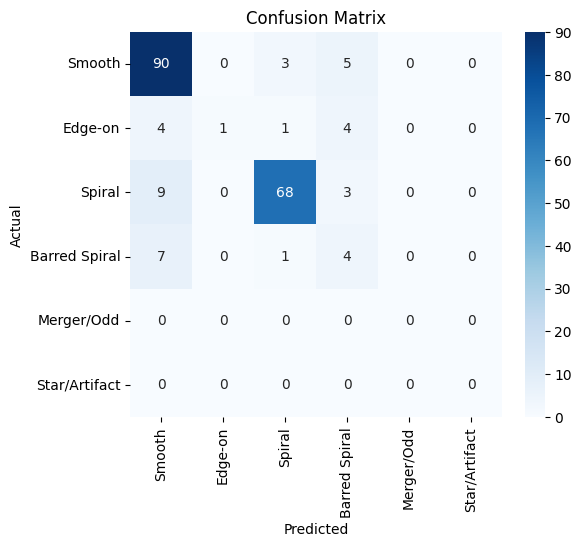


Showing 5 sample predictions:


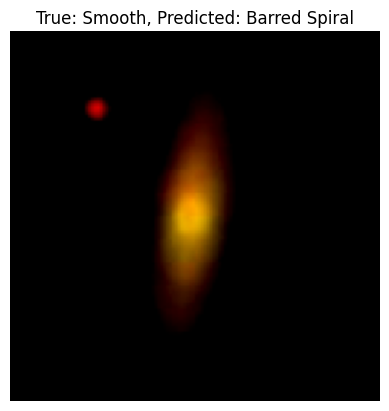

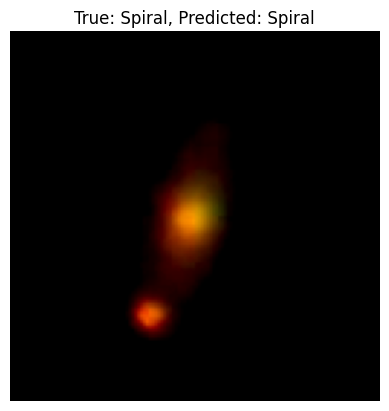

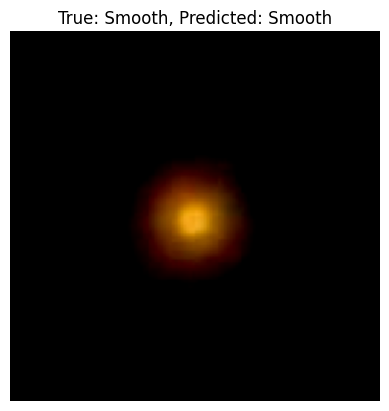

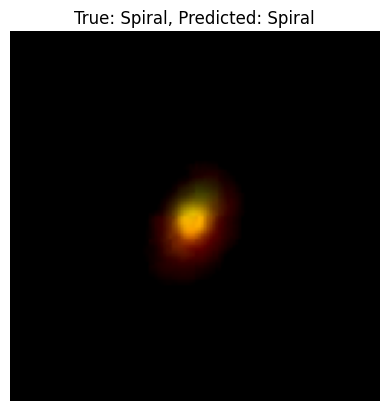

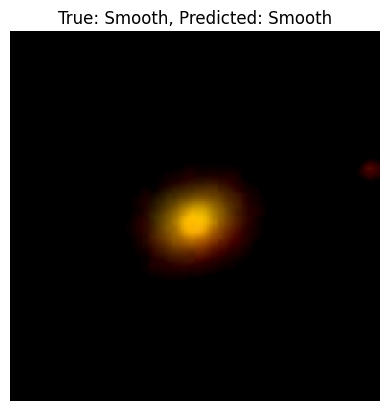

In [103]:

multi_class_names = [
    "Smooth",        # 0
    "Edge-on",       # 1
    "Spiral",        # 2
    "Barred Spiral", # 3
    "Merger/Odd",    # 4
    "Star/Artifact"  # 5
]

evaluate_model(
    multi_model,
    multi_test_loader,
    device,
    class_names=multi_class_names,
    num_images_to_show=5
)


C:\Users\RIYA\AppData\Local\Temp\ipykernel_19448\234699762.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='extended_label', data=mapping_df, palette=colors)
C:\Users\RIYA\AppData\Local\Temp\ipykernel_19448\234699762.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(x='extended_label', data=mapping_df, palette=colors)


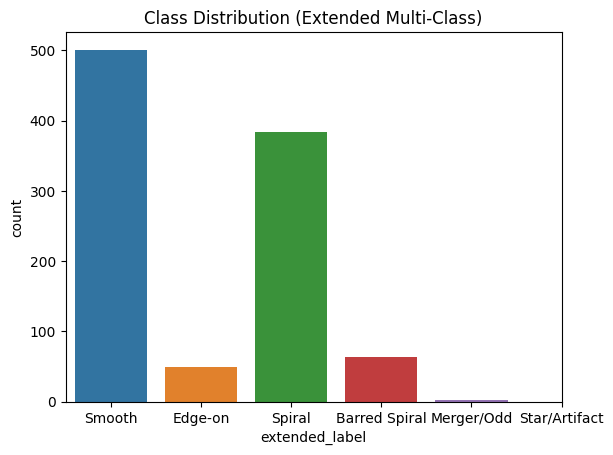

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors for 6 classes
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

# Plot class distribution for extended labels
sns.countplot(x='extended_label', data=mapping_df, palette=colors)

# Set tick labels to match extended class names
plt.xticks(
    [0, 1, 2, 3, 4, 5],
    ["Smooth", "Edge-on", "Spiral", "Barred Spiral", "Merger/Odd", "Star/Artifact"]
)

plt.title("Class Distribution (Extended Multi-Class)")
plt.show()
